# Spoken Digit Classification

In [154]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp
%matplotlib inline
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd



# Define features

## Zero crossing rate

In [157]:
def compute_zcr(win, Fs):
    # returns an array of 1 (value > 0) and 0 (value < 0)
    win_sign = np.sign(win)
    # length calculated across input dimension (in this case 0)
    N = win.shape[0]
    # difference inside the formula 
    # (NB win_sign[:-1] means from first to the second last, so the last is excluded)
    sign_diff = np.abs(win_sign[:-1] - win_sign[1:])
    
    zcr = np.sum(sign_diff) * Fs / (2 * N)
    zcr = len(sign_diff[sign_diff != 0]) * Fs / N
    return zcr

## Spectral decrease

In [158]:
def compute_specdec(spec):
    mul_fact = 1 / (np.sum(np.abs(spec[1:])))
    num = np.abs(spec[1:]) - np.abs(spec[0])
    den = np.arange(1, len(spec)) - 1
    den[den == 0] = 1
    spectral_decrease = mul_fact * np.sum(num / den)
    return spectral_decrease

## Spectral centroid

In [159]:
def compute_speccentr(spec, Fs):
    freq_axis = np.linspace(0, Fs//2, len(spec))
    centr = np.dot(freq_axis, np.abs(spec)) / np.sum(np.abs(spec), axis = 0)
    return centr

## MFCC

In [88]:
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133.33,
        fmax=6853.8,
    )
    
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    return mfcc

## import recordings

In [160]:
# define the dictionary containing the 10 classes
class_train_files = {'zero': [], 'one': [], 'two': [], 'three': [], 'four': [], 'five': [], 'six': [], 'seven': [], 'eight': [], 'nine': []}

root = '../free-spoken-digit-dataset/recordings'
for f in os.listdir(root):
    for index, c in enumerate(class_train_files):
        if int(f[0]) == index:
            class_train_files[c].append(f)

In [90]:
# listen to an audio file
audio, fs = librosa.load(os.path.join(root, class_train_files['eight'][2]), sr=None)
ipd.Audio(audio, rate=fs) # load the file

## Split dataset

In [91]:
df = pd.DataFrame(class_train_files)
# split the data into train and test set (for now 10% test)
train, test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
print(train.shape[0])
print(test.shape[0])

x = np.empty(train.shape[0], object)

270
30


## compute MFCC

In [161]:
# initialize dictionaries
dict_train_mfcc = {'zero': [], 'one': [], 'two': [], 'three': [], 'four': [], 'five': [], 'six': [], 'seven': [], 'eight': [], 'nine': []}
dict_test_mfcc = {'zero': [], 'one': [], 'two': [], 'three': [], 'four': [], 'five': [], 'six': [], 'seven': [], 'eight': [], 'nine': []}


# why 13? try different values. check warning
n_mfcc = 13

df_list = [train, test]

# for train and test
for index, data in enumerate(df_list):
    # for each class
    for c in data:
        # set up array for storing mfcc
        if index == 0:
            dict_train_mfcc[c] = np.zeros(((len(data[c])), n_mfcc))
        else:
            dict_test_mfcc[c] = np.zeros(((len(data[c])), n_mfcc))
        #temp_features = np.zeros(((len(data[c])), n_mfcc))
        # compute mfcc
        for index2, f in enumerate(data[c]):
            audio, fs = librosa.load(os.path.join(root, f), sr=None)
            mfcc = compute_mfcc(audio, fs, n_mfcc)
            #temp_features[index2, :] = np.mean(mfcc, axis=1)
            # store results for current class and file
            if index == 0:
                dict_train_mfcc[c][index2, :] = np.mean(mfcc, axis=1)
            else:
                dict_test_mfcc[c][index2, :] = np.mean(mfcc, axis=1)
print('finished')

/home/francescozumo/miniconda3/envs/CMLS/lib/python3.7/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


finished


In [162]:
# check one mfcc
dict_train_mfcc['one'][25]

array([ 20.36855888, -14.86614227,  12.6977663 ,  -8.94446945,
         5.06823206,  -0.75446075,  -1.28136218,   3.31976247,
        -3.75481725,   3.54810596,  -2.81019616,   1.27820492,
         0.47228062])

## compute other features

In [163]:
train_basic_features = {'zcr':  np.empty(train.shape[0], object), 'spec_cent':np.empty(train.shape[0], object)}
test_basic_features = {'zcr':  np.empty(test.shape[0], object), 'spec_cent':np.empty(test.shape[0], object)}

# check parameters
win_length = int(np.floor(0.01 * fs))
hop_size = int(np.floor(0.0075 * fs))

window = sp.signal.get_window(window='hanning', Nx=win_length)
n_features = len(train_basic_features)

In [165]:
dict_train_basic = {'zero': [], 'one': [], 'two': [], 'three': [], 'four': [], 'five': [], 'six': [], 'seven': [], 'eight': [], 'nine': []}
dict_test_basic = {'zero': [], 'one': [], 'two': [], 'three': [], 'four': [], 'five': [], 'six': [], 'seven': [], 'eight': [], 'nine': []}

# for train and test
for df_index, data in enumerate(df_list):
    # for each class
    for c in data:
        if df_index == 0:
            dict_train_basic[c] = {'zcr':  np.empty(train.shape[0], object), 'spec_cent':np.empty(train.shape[0], object)}
        else:
            dict_test_basic[c] = {'zcr':  np.empty(test.shape[0], object), 'spec_cent':np.empty(test.shape[0], object)}
        # for each audio file
        for index, f in enumerate(data[c]):
            audio, fs = librosa.load(os.path.join(root, f), sr=None)
            n_windows = int(np.floor(audio.shape[0] - win_length) / hop_size)
            if df_index == 0:
                dict_train_basic[c]['zcr'][index] = librosa.feature.zero_crossing_rate(audio, win_length, hop_size)
                dict_train_basic[c]['spec_cent'][index] = librosa.feature.spectral_centroid(y=audio, sr=fs, n_fft=win_length, hop_length=hop_size, window=window)
                #dict_train_basic[c]['spec_decr'][index] = []
            else:
                dict_test_basic[c]['zcr'][index] = librosa.feature.zero_crossing_rate(audio, win_length, hop_size)
                dict_test_basic[c]['spec_cent'][index] = librosa.feature.spectral_centroid(y=audio, sr=fs, n_fft=win_length, hop_length=hop_size, window=window)
                #dict_test_basic[c]['spec_decr'][index] = []
print("finished")

finished


In [166]:
# check some results
print(dict_train_basic['seven']['zcr'].shape[0])
print(dict_train_basic['seven'][feat][0][0])

270
[2751.95787924 2386.3366778  2330.62626887 1706.60949373  534.41292194
  926.91682158  872.44819176  932.54456152  826.27629111 1011.46511321
  897.91072564  965.47075332 1039.41004872 1020.71402585  994.66947599
 1001.00299079  927.28684576  843.52957204  921.65550016  689.63146222
  829.9687409   830.38606149  610.53934091  648.59269584  731.43130117
  533.44684235  482.71892213  746.22806528  531.79090456  532.34311457
  562.27569496  737.84222676  648.08943861  549.12132813  528.10673831
  651.1778802   662.83009985  530.59961969  559.1872454   499.04243886
  508.70630686  393.71735811  456.24604969  468.33695434  480.17412563
  469.41757051  545.63504496  648.38647483  428.01450389  504.4892769
  372.34187242  735.5835499   575.93150936  515.99776629  740.4170722
  414.04111583  863.05826106  548.43337133]


## Plot basic features

In [184]:
# the result shows that they are not a solution for our problem
for feat_index, feat in enumerate(train_basic_features):
    plt.figure(figsize = (16, 8))
    print(feat)
    sns.histplot(dict_train_basic['two'][feat][1][0], label = 'Histogram for class 0 pf feature {}'.format(feat), 
                 kde=True, color='red', bins=25)
    sns.histplot(dict_train_basic['three'][feat][1][0], label = 'Histogram for class 1 pf feature {}'.format(feat), 
                 kde=True, color='blue', bins=25)
    plt.legend()
    plt.grid(True)
    plt.show()

zcr
spec_cent


## Plot MFCC 

In [168]:
dict_train_mfcc['two']

array([[ 1.91730289e+01, -1.48379946e+01,  1.32139606e+01, ...,
        -2.81582689e+00,  1.09383523e+00,  2.52270736e-02],
       [ 1.92735977e+01, -1.53947144e+01,  1.40550117e+01, ...,
        -3.17849422e+00,  1.51351297e+00, -2.28363320e-01],
       [ 1.93923225e+01, -1.51498394e+01,  1.33809967e+01, ...,
        -2.72529483e+00,  1.08202136e+00, -6.12255186e-02],
       ...,
       [ 1.88040237e+01, -1.50595236e+01,  1.39876289e+01, ...,
        -2.79860544e+00,  9.30507898e-01,  1.96129292e-01],
       [ 2.07350864e+01, -1.51345873e+01,  1.34223166e+01, ...,
        -2.59368873e+00,  9.85125721e-01, -2.26048425e-01],
       [ 1.77788544e+01, -1.50577879e+01,  1.31271868e+01, ...,
        -2.87093616e+00,  1.42635965e+00, -1.59377363e-02]])

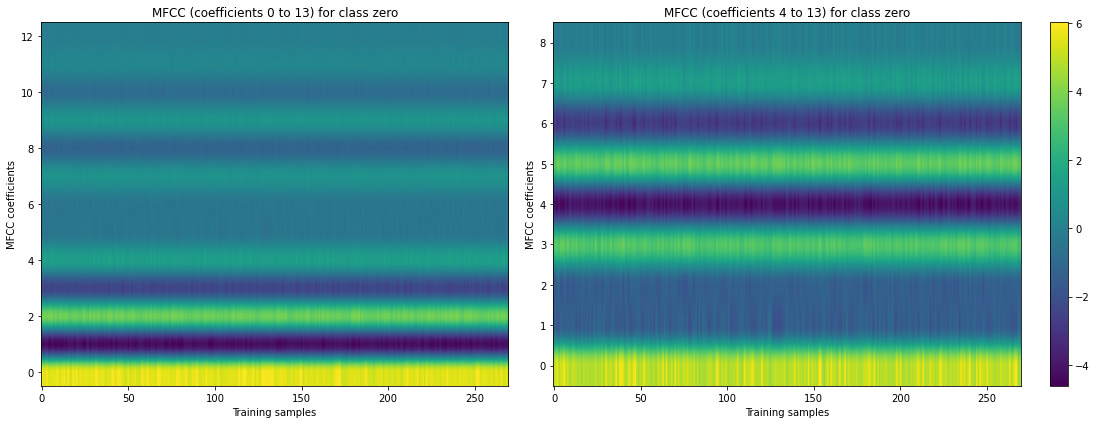

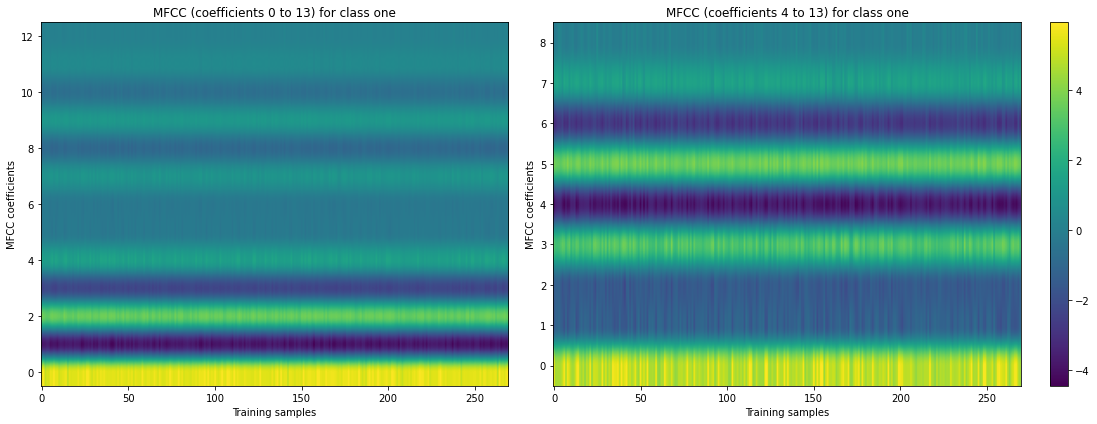

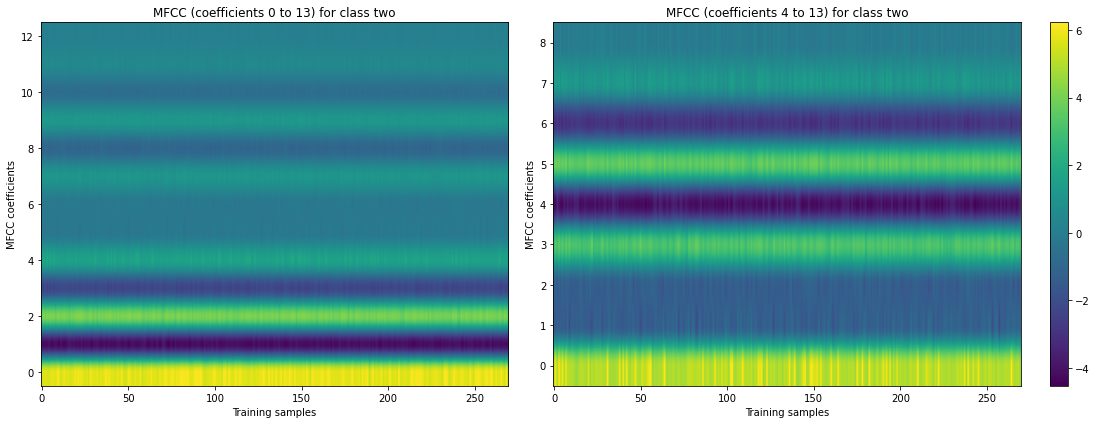

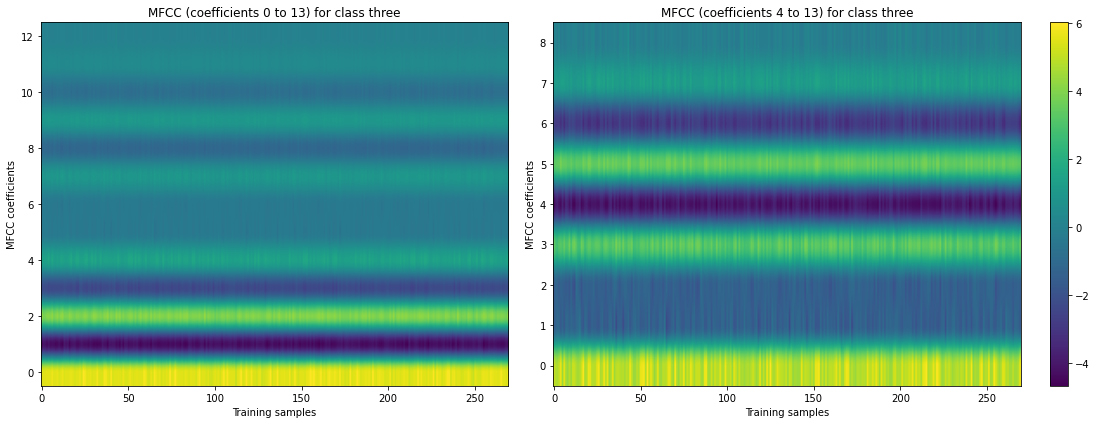

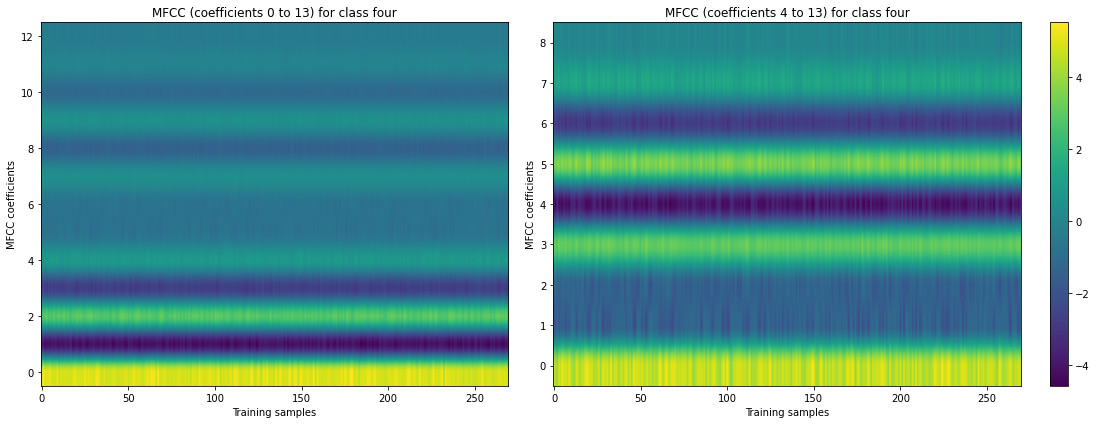

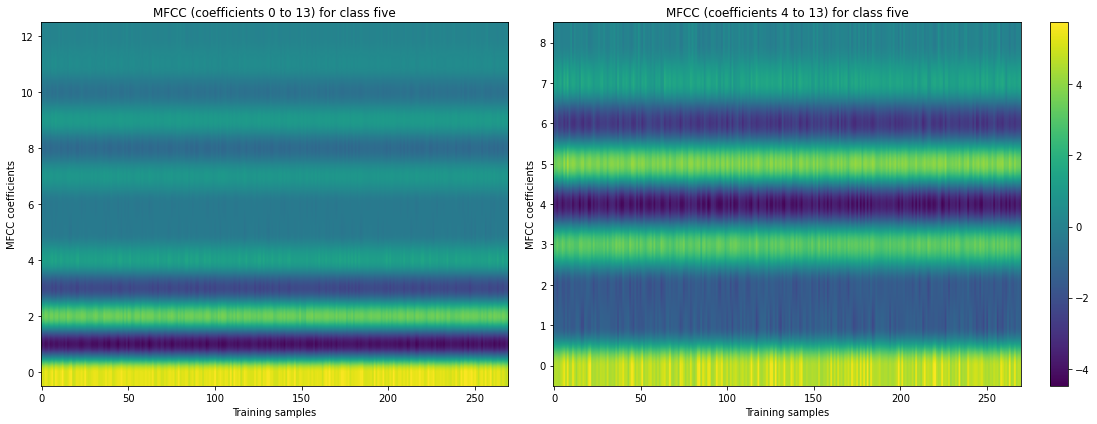

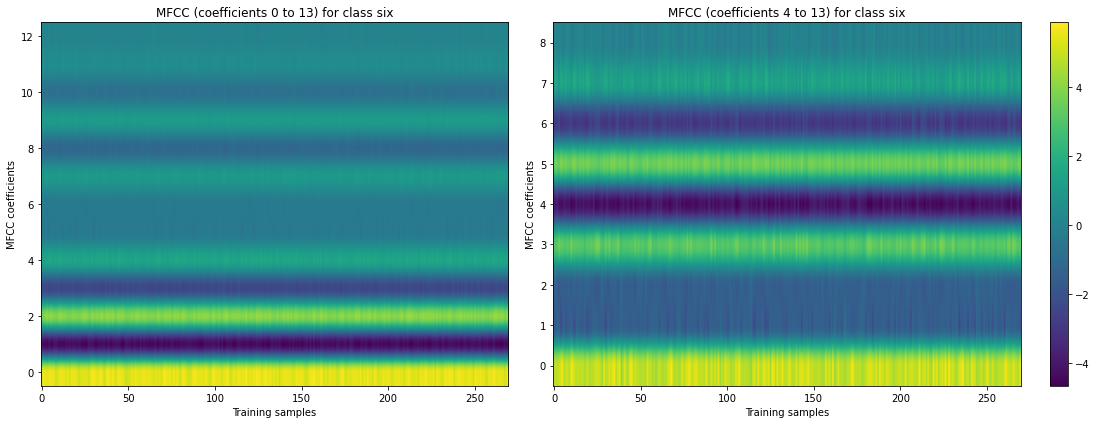

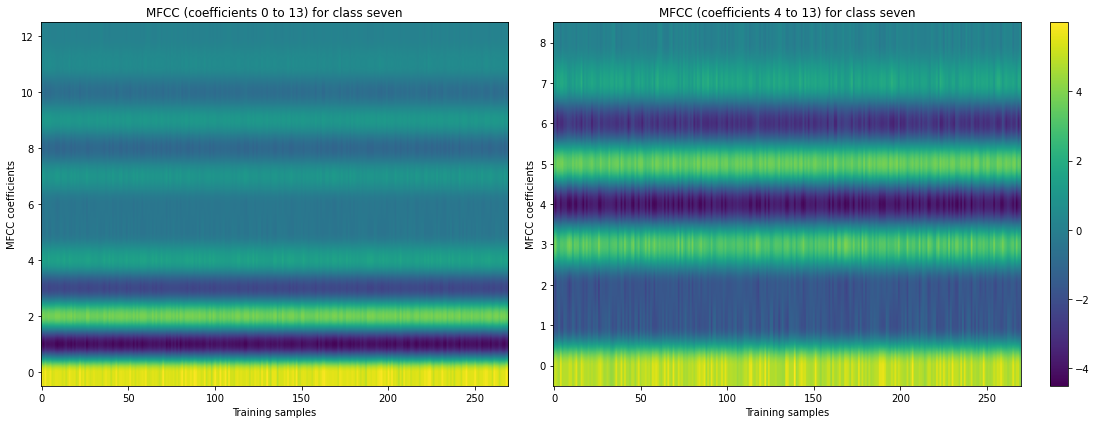

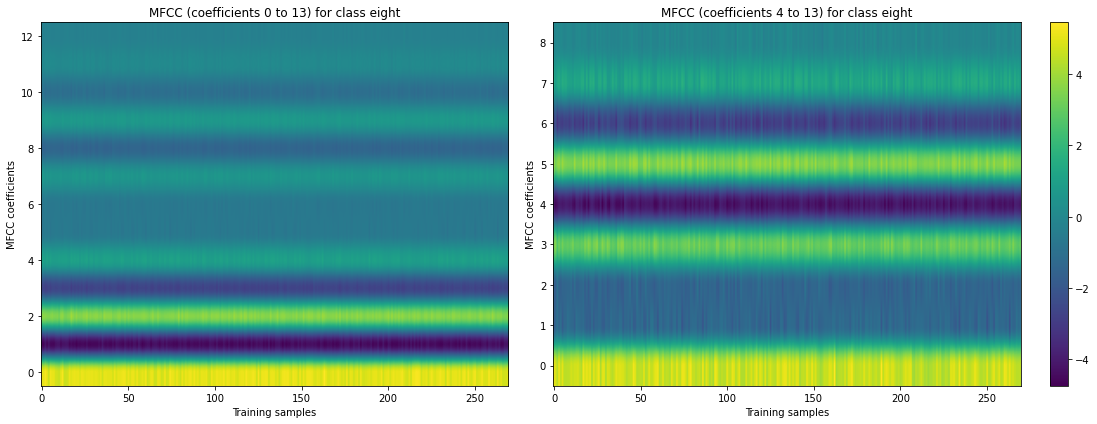

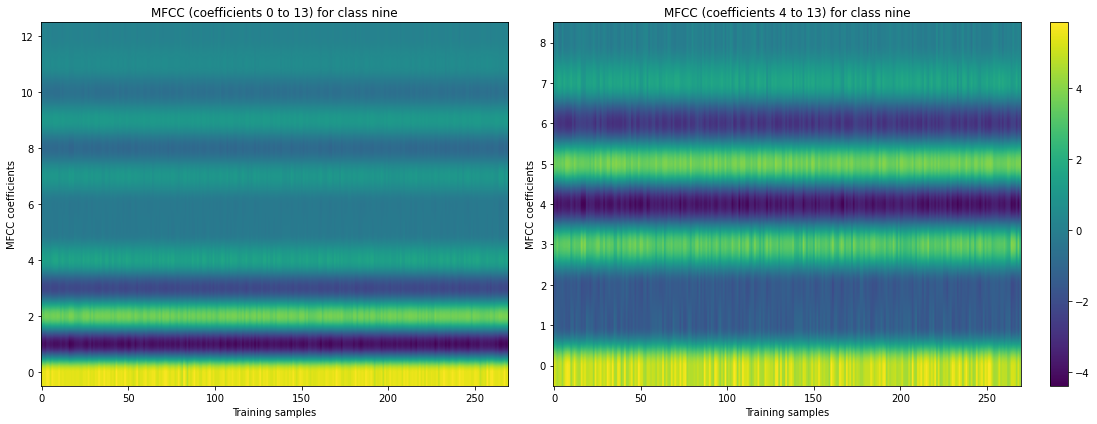

In [169]:
#plt.figure(figsize = (16, 8))
#print("plotting MFCC")
#sns.histplot(dict_train_mfcc['zero'][1], label = 'Histogram for class 0 pf feature {}'.format(feat), 
#             kde=True, color='red', bins=25)
#sns.histplot(dict_train_mfcc['zero'][1], label = 'Histogram for class 1 pf feature {}'.format(feat), 
#             kde=True, color='blue', bins=25)
#plt.legend()
#plt.grid(True)
#plt.show()

for c in dict_train_mfcc:
    mfcc = dict_train_mfcc[c].transpose()
    # Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

## Mixture Gaussian Model

In [170]:
n_components = 3

gmm_0 = BayesianGaussianMixture(n_components=n_components, random_state=2)
gmm_1 = BayesianGaussianMixture(n_components=n_components, random_state=2)

In [171]:
gmm_0.fit(dict_train_mfcc['zero'])
gmm_1.fit(dict_train_mfcc['one'])
gmm_0.means_

array([[ 2.00922749e+01, -1.54563875e+01,  1.40818028e+01,
        -8.66797939e+00,  5.45414279e+00, -1.45963908e+00,
        -1.52221369e+00,  3.37925188e+00, -4.35312898e+00,
         3.47148152e+00, -2.86125506e+00,  1.21655698e+00,
        -1.33351849e-01],
       [ 1.99631736e+01, -1.49768895e+01,  1.29061498e+01,
        -8.12496150e+00,  4.77101001e+00, -1.32282642e+00,
        -1.39096019e+00,  2.99631747e+00, -3.89467393e+00,
         3.31332908e+00, -2.67162417e+00,  1.29825490e+00,
        -9.50425580e-02],
       [ 2.15303409e+01, -1.49170649e+01,  1.34390617e+01,
        -8.36783203e+00,  5.02734664e+00, -1.80964987e+00,
        -1.35547038e+00,  3.15147989e+00, -4.24116694e+00,
         3.63926277e+00, -2.82942898e+00,  1.29714637e+00,
        -1.54601146e-02]])

## concatenate dict fields

In [234]:
dict_test_mfcc_all = np.concatenate((dict_test_mfcc['zero'], dict_test_mfcc['one']), axis=0)
#dict_test_mfcc_all = dict_test_mfcc['zero']
#for c in dict_test_mfcc:
#    if c == "zero":
#        continue
#    dict_test_mfcc_all = np.concatenate((dict_test_mfcc_all, dict_test_mfcc[c]), axis=0)

dict_test_mfcc['zero'].shape

(30, 13)

In [213]:
mixt_pdf_0 = []
mixt_pdf_1 = []

sample_0 = []
sample_1 = []

for n in np.arange(n_components):
    mixt_gauss_0 = sp.stats.multivariate_normal(gmm_0.means_[n, :], gmm_0.covariances_[n, :], allow_singular=True)
    mixt_gauss_1 = sp.stats.multivariate_normal(gmm_1.means_[n, :], gmm_1.covariances_[n, :], allow_singular=True)
    
    # fix pdf
    mixt_pdf_0.append(gmm_0.weights_[n] * mixt_gauss_0.pdf(dict_test_mfcc_all))
    mixt_pdf_1.append(gmm_1.weights_[n] * mixt_gauss_1.pdf(dict_test_mfcc_all))
    
    sample_0.append(mixt_gauss_0.rvs(np.int(500 * gmm_0.weights_[n])))
    sample_1.append(mixt_gauss_1.rvs(np.int(500 * gmm_1.weights_[n])))
print("finished")

finished


In [218]:
pdf_0 = np.sum(mixt_pdf_0, axis=0).reshape(-1, 1)
pdf_1 = np.sum(mixt_pdf_1, axis=0).reshape(-1, 1)

pdf = np.concatenate((pdf_0, pdf_1), axis=1)

predicted_test_labels = np.argmax(pdf, axis=1)

## plot samples from the mixture

In [220]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

markers = ['x', 'o', '*']

for n in np.arange(n_components):
    x = sample_0[n][:, 0]
    y = sample_0[n][:, 1]
    z = sample_0[n][:, 2]
    ax.scatter(x, y, z, c='r', marker=markers[n])
    
    x = sample_1[n][:, 0]
    y = sample_1[n][:, 1]
    z = sample_1[n][:, 2]
    ax.scatter(x, y, z, c='b', marker=markers[n])
    
plt.show()

Using matplotlib backend: Qt5Agg


## create test label array

In [ ]:
test_labels = np.Array

## define metrics

In [221]:
def compute_metrics(gt_labels, predicted_labels):
    TP = np.sum(np.logical_and(predicted_labels==1, gt_labels==1))
    TN = np.sum(np.logical_and(predicted_labels==0, gt_labels==0))
    FP = np.sum(np.logical_and(predicted_labels==1, gt_labels==0))
    FN = np.sum(np.logical_and(predicted_labels==0, gt_labels==1))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    F1_score = 2 * precision * recall / (precision + recall)
    
    print("Results: \n accuracy = {} \n precision = {} \n recall = {} \n F1 score = {}".format(
        accuracy, precision, recall, F1_score))

In [228]:
predicted_test_labels.shape

(2700,)

In [178]:
compute_metrics(test_labels, predicted_test_labels)

NameError: name 'test_labels' is not defined

NameError: name 'test_labels' is not defined

## SVM multiclass

In [17]:
SVM_parameters={ 'C': 1, 'kernel': 'rbf', }
clf = []
clf


[]

In [48]:
SVM_parameters={ 'C': 1, 'kernel': 'rbf', }
clf = []
for i in np.arange(10):
    for j in np.arange(10):
        if j > i:
            clf.append(sklearn.svm.SVC(**SVM_parameters, probability=True))
            # later add normalization
            clf[-1].fit(dict_train_features[classes[i]], dict_train_features[classes[j]])

ValueError: y should be a 1d array, got an array of shape (1500, 10) instead.

In [129]:
X_train = []
X_test = []
X_train_max = np.zeros(10)
X_train_min = np.zeros(10)

for i in np.arange(10):
    X_train.append(dict_train_features[classes[i]])
    X_test.append(dict_test_features[classes[i]])
    X_train_max[i] = np.max(dict_train_features[classes[i]], axis=0)
    X_train_min[i] = np.min(dict_train_features[classes[i]], axis=0)
    
feat_max = np.max(X_train_max, axis=0)
feat_min = np.min(X_train_min, axis=0)

X_train_normalized = []
X_test_normalized = []

for i in np.arange(10):
    X_train_normalized.append((X_train[i] - feat_min) / (feat_max - feat_min))
    X_test_normalized.append((X_test[i] - feat_min) / (feat_max - feat_min))

X_test_mc_normalized = X_test_normalized[0]
for i in np.arange(1,10):
    X_test_mc_normalized = np.concatenate((X_test_mc_normalized, X_test_normalized[i]), axis=0)

NameError: name 'dict_train_features' is not defined

### Notes

In [ ]:
# maybe check if volume is constant in each recording
# also duration seems to change, is this a problem?